## Get the Data

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import tweepy
import re
import twitterconfig as tc
#from sklearn import datasets
from nltk import ngrams

In [2]:
#!pip install tweepy
#!pip install wordcloud

In [3]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



In [4]:
def remove_url(text):
    return re.sub(r'http\S+', '', text)

In [5]:
remove_url('this is to test http://localhost:8888/notebooks/ how to remove url ')

'this is to test  how to remove url '

### To be able to download twitter data
* Sign in to twitter and go to: https://developer.twitter.com/

* After logging in to the portal, and going to "Applications", a new application can be created which will provide the needed data for communicating with Twitter API.

In [ ]:
import tweepy

# Variables that contains the user credentials to access Twitter API 
ACCESS_TOKEN = tc.ACCESS_TOKEN
ACCESS_TOKEN_SECRET = tc.ACCESS_TOKEN_SECRET 
CONSUMER_KEY = tc.CONSUMER_KEY 
CONSUMER_SECRET = tc.CONSUMER_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth,wait_on_rate_limit=True)
        
with open("test_twitter1.txt", "w") as file:
    # you ignore all retweets by adding -filter:retweets to your query.
    for tweet_info in tweepy.Cursor(api.search, q='Python', lang = 'en', tweet_mode='extended').items(10):
        #(not tweet.retweeted) and ('RT @' not in tweet.text)
        if 'retweeted_status' in dir(tweet_info):
            full_text = tweet_info.retweeted_status.full_text
        else:
            full_text = tweet_info.full_text

        full_text = remove_emoji(full_text)
        no_urls_no_tags = " ".join([word for word in full_text.split()
                                    if 'http' not in word
                                        and not word.startswith('@')
                                        and word != 'RT'
                                    ])
        # save the tweet to the file
        file.write(no_urls_no_tags+"\n")

        print(tweet_info._json['user']['screen_name'],':',no_urls_no_tags)
        print(no_urls_no_tags)
        print('-----')
   


In [ ]:
with open('test_twitter1.txt') as f:
    content = f.read()
    
wordcloud = WordCloud(
                      #font_path='/Users/decimal/Library//R/3.2/library/rmarkdown/rmd/h/bootstrap-3.3.5/css/fonts/Roboto.ttf',
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(content)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('my_wordcloud_1.png', dpi=300)
plt.show()

### Read Data

We'll use Pandas's **read_csv**, to load an already existing dataset


In [6]:
df = pd.read_csv(r'testdata.manual.2009.06.14.csv',header=None, encoding="cp1252")

In [7]:
# data does not have column names so let's provide them
df.columns = ['polarity', 'tweet ID', 'date', 'query', 'username' , 'tweet']
df.head()

,polarity,tweet ID,date,query,username,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


### We are interested in two columns only: 'tweet' and 'polarity'

In [8]:
df = df[['tweet','polarity']]
df.head()

,tweet,polarity
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,4
1,Reading my kindle2... Love it... Lee childs i...,4
2,"Ok, first assesment of the #kindle2 ...it fuck...",4
3,@kenburbary You'll love your Kindle2. I've had...,4
4,@mikefish Fair enough. But i have the Kindle2...,4


In [9]:
## let's change column names for compatibility
df.columns = ['Text', 'Category']

## Exploratory Data Analysis

In [10]:
df.head()

,Text,Category
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,4
1,Reading my kindle2... Love it... Lee childs i...,4
2,"Ok, first assesment of the #kindle2 ...it fuck...",4
3,@kenburbary You'll love your Kindle2. I've had...,4
4,@mikefish Fair enough. But i have the Kindle2...,4


In [11]:
df['Category'].value_counts()

4    182
0    177
2    139
Name: Category, dtype: int64

In [12]:
df.describe()

,Category
count,498.000000
mean,2.020080
std,1.699686
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,4.000000


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate different categories

In [13]:
df.groupby('Category').describe()

Text                                                               
         count unique                                                top freq
Category                                                                     
0          177    177  RT @sportsguy33 The upside to Time Warner: unh...    1
2          139    139  Google Wave Developer Sandbox Account Request ...    1
4          182    182  Obama's speech was pretty awesome last night! ...    1

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of text classification in general. I encourage you to read up on the topic!

Let's make a new column to detect how long each text entry is!

In [14]:
# length here is the number of chars
df['length'] = df['Text'].apply(len)
df.head()

,Text,Category,length
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,4,111
1,Reading my kindle2... Love it... Lee childs i...,4,58
2,"Ok, first assesment of the #kindle2 ...it fuck...",4,58
3,@kenburbary You'll love your Kindle2. I've had...,4,140
4,@mikefish Fair enough. But i have the Kindle2...,4,75


In [15]:
df['Text'][321]

"I'm moving to East Palo Alto!"

### Some Data Visualization

C:\Users\decim\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


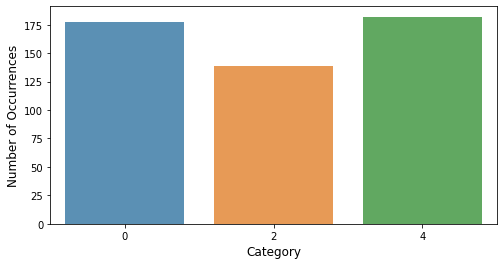

In [16]:
# Are the classes balanced?
count_target = df['Category'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12);

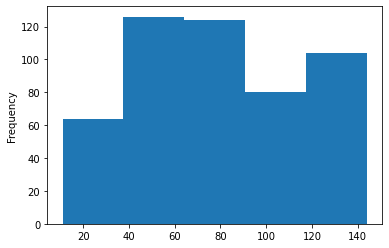

In [17]:
df['length'].plot(bins=5, kind='hist');

Play around with the bin size! Looks like text length may be a good feature to think about!

In [18]:
df.length.describe()

count    498.000000
mean      80.411647
std       35.790319
min       11.000000
25%       53.250000
50%       75.000000
75%      108.000000
max      144.000000
Name: length, dtype: float64

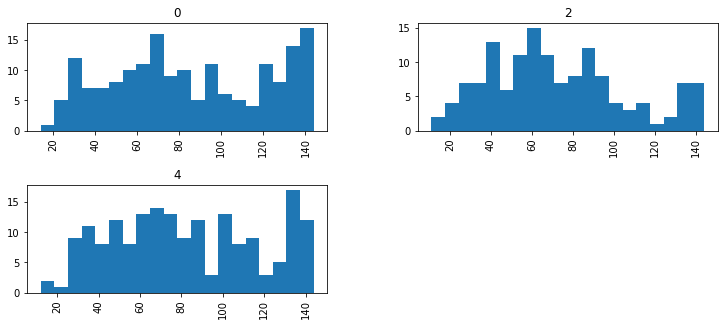

In [19]:
df.hist(column='length', by='Category', bins=20,figsize=(12,5));

## Text Pre-processing

The main issue with our data is that it is all in text format (strings). To be able to use classification algorithms we will need some sort of numerical feature vector in order to perform the classification tasks. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


** In this section we'll convert the raw text (sequence of characters) into vectors (sequences of numbers) **

As a first step, let us write a function that splits a text line (i.e. a file or tweet) into its individual words and returns a list. We will also remove very common words, ('the', 'a', etc..). To do this we will take advantage of a text file that contains a list of very common words (i.e. stopwords).

In addition we will perform two steps: text stemming and ngram tokenisation which are common techniques in text preprocessing.

Let's create a function that will process the string in the **Text** column, then we can just use **apply()** in pandas to process all the text in the DataFrame.

### To Remove Stopwords 
* Here we prepare a list of stopwords
* We import a list of english stopwords from a text file
* We later remove these words from the input text

In [21]:
my_stopwords = []
with open(r'stopwords_en.txt') as f:
    my_stopwords = f.read().splitlines()

### NGram Tokenisation
Now let's write a function to "tokenise" the text lines (i.e. files). Tokenisation is the term used to describe the process of converting the normal text strings in to a list of tokens (words or sentences that we actually want).

* Here we apply ngram tokenisation
* This function receives a text list where each element is a string in a text
* e.g. ['take', 'a', 'string', 'text']
* Also the number of tokens n .. default is 3
* It returns the tokenised string as a list of tokens .. e.g. ['take a string', 'a string text']

In [22]:
def ngram_vectoriser(text_list, n=3):
    ngram_feature_vector = []
    for item in ngrams(text_list, n):
        ngram_feature_vector.append(' '.join(item))
    return ngram_feature_vector

### You can also use NLTK

* from nltk.tokenize import word_tokenize

* from nltk.corpus import stopwords 

### Negation Handling

In [23]:
import re

negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def handle_negation(text):
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
    return neg_handled

## Now let's write a Function to Prepare Text
We will apply it to our DataFrame later on
### This function receives a text string and performs the following:
* Convert text to lower case
* Remove emojis
* Remove URLs
* Handle negation
* Remove punctuation marks
* Remove stop words using the list we prepared previously
* Apply stemming using the popular Snowball or Porter Stemmer
* Apply NGram Tokenisation
* Return the tokenised text as a list

In [26]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

#stemmer = SnowballStemmer("english", ignore_stopwords=True)
stemmer = PorterStemmer()

import string
def process_text(text):
    """
    Takes in a string of text, then performs the following:
    1. Convert text to lower case 
    2. remove all punctuation
    3. Remove emojis 
    4. remove URLs
    5. Handle Negation
    6. Remove all stopwords
    7. Apply Stemming
    8. Apply Ngram Tokenisation
    9. Returns the tokenised text as a list
    """
    # 1
    text = text.lower()
    # 2
    text = remove_emoji(text)
    # 3 
    text = remove_url(text)
    # 4 
    text = handle_negation(text)
    # 5 
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # 6
    # Now just remove any stopwords
    no_stop_words = [word for word in nopunc.split() if word.lower() not in my_stopwords]
    # 7 
    # apply stemming
    stemmed = [stemmer.stem(word) for word in no_stop_words]
    # 8 
    #apply ngram tokenisation
    tokenised = ngram_vectoriser(stemmed,2)
    # 9
    return tokenised

In [27]:
process_text('Now well convert each text, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.')

['convert text',
 'text repres',
 'repres list',
 'list token',
 'token lemma',
 'lemma vector',
 'vector machin',
 'machin learn',
 'learn model',
 'model understand']

In [28]:
remove_url('@switchfoot http://twitpic.com/2y1zl - Awww')

'@switchfoot  - Awww'

Here is the original DataFrame again:

In [29]:
df.head()

,Text,Category,length
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,4,111
1,Reading my kindle2... Love it... Lee childs i...,4,58
2,"Ok, first assesment of the #kindle2 ...it fuck...",4,58
3,@kenburbary You'll love your Kindle2. I've had...,4,140
4,@mikefish Fair enough. But i have the Kindle2...,4,75


In [30]:
# Check to make sure its working
df['Text'].head(5).apply(process_text)

0    [stellargirl loooooooovvvvvvee, loooooooovvvvv...
1    [read kindle2, kindle2 love, love lee, lee chi...
2    [ok asses, asses kindle2, kindle2 fuck, fuck r...
3    [kenburbari youll, youll love, love kindle2, k...
4    [mikefish fair, fair kindle2, kindle2 think, t...
Name: Text, dtype: object

## Vectorization

Currently, we have the text file contents as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those texts into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each text, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each text (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the text file corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 2nd-dimension is the entire vocabulary (1 column per word) and the other dimension will have the actual documents, in this case a row per text. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Word 1 Count</th> <th>Word 2 Count</th> <th>...</th> <th>Word M Count</th> 
</tr>
<tr>
<td><b>File 1</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>File 2</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>File N</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many text files and words, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [33]:
# Might take a while...
# You can save this for future use .. e.g. to apply on new text
bow_transformer = CountVectorizer(analyzer=process_text).fit(df['Text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))
print(bow_transformer.vocabulary_)

3096
{'stellargirl loooooooovvvvvvee': 2561, 'loooooooovvvvvvee kindle2': 1671, 'kindle2 dx': 1516, 'dx cool': 783, 'cool 2': 590, '2 fantast': 21, 'fantast right': 873, 'read kindle2': 2207, 'kindle2 love': 1519, 'love lee': 1694, 'lee child': 1597, 'child good': 504, 'good read': 1077, 'ok asses': 2006, 'asses kindle2': 209, 'kindle2 fuck': 1517, 'fuck rock': 972, 'kenburbari youll': 1500, 'youll love': 3086, 'love kindle2': 1691, 'kindle2 ive': 1518, 'ive month': 1420, 'month look': 1807, 'look new': 1666, 'new big': 1885, 'big huge': 311, 'huge need': 1296, 'need remors': 1875, 'mikefish fair': 1786, 'fair kindle2': 867, 'kindle2 think': 1523, 'think perfect': 2684, 'richardebak big': 2274, 'big im': 313, 'im quit': 1333, 'quit happi': 2194, 'happi kindle2': 1184, 'fuck economi': 969, 'economi hate': 801, 'hate aig': 1192, 'aig non': 113, 'non loan': 1954, 'loan given': 1644, 'given ass': 1011, 'jqueri new': 1451, 'new best': 1884, 'best friend': 298, 'love twitter': 1704, 'love ob

Let's take one text and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [34]:
data4 = df['Text'][3]
print(data4)

@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)


Now let's see its vector representation:

In [35]:
bow4 = bow_transformer.transform([data4])
print(bow4)
print(bow4.shape)

  (0, 311)	1
  (0, 1296)	1
  (0, 1420)	1
  (0, 1500)	1
  (0, 1518)	1
  (0, 1666)	1
  (0, 1691)	1
  (0, 1807)	1
  (0, 1875)	1
  (0, 1885)	1
  (0, 3086)	1
(1, 3096)


This means that there are several unique words in text file number 4 (after removing common stop words). We can see how many times each of them appears!

In [36]:
#Test
print(bow_transformer.get_feature_names()[65])
print(bow_transformer.get_feature_names()[355])

6pm let
boo time


In [38]:
# get the ID of a term
bow_transformer.vocabulary_['sick child']

2447

In [39]:
#get the frequency of term with ID 70712
bow4.toarray()[0,556]

0

Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of text file contents. Let's go ahead and check out how the bag-of-words counts for the entire corpus in a large, sparse matrix:

In [40]:
text_bow = bow_transformer.transform(df['Text'])

In [41]:
print('Shape of Sparse Matrix: ', text_bow.shape)
print('Amount of Non-Zero occurences: ', text_bow.nnz)

Shape of Sparse Matrix:  (498, 3096)
Amount of Non-Zero occurences:  3366


In [42]:
sparsity = (100.0 * text_bow.nnz / (text_bow.shape[0] * text_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.21831512094891192


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents that contain term t).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word **cat** appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word **cat** appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the TF-IDF weight is the product of these quantities: 0.03 * 4 = 0.12.
____

<table border = “1“>
<tr>
<th></th> <th>Word 1 Weight</th> <th>Word 2 Weight</th> <th>...</th> <th>Word M Weight</th> 
</tr>
<tr>
<td><b>File 1</b></td><td>0.033</td><td>1.092</td><td>...</td><td>1.301</td>
</tr>
<tr>
<td><b>File 2</b></td><td>2.98</td><td>1.106</td><td>...</td><td>0.093</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>2.102</td>
</tr>
<tr>
<td><b>File N</b></td> <td>0.173</td><td>0618</td><td>...</td><td>0.602</td>
</tr>
</table>

_____________


Let's go ahead and see how we can do this in SciKit Learn:

In [ ]:
x

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
# You can save this for future use .. e.g. to apply on new text
tfidf_transformer = TfidfTransformer().fit(text_bow)

tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 3086)	0.30602159009044216
  (0, 1885)	0.30602159009044216
  (0, 1875)	0.30602159009044216
  (0, 1807)	0.30602159009044216
  (0, 1691)	0.2734854540213297
  (0, 1666)	0.30602159009044216
  (0, 1518)	0.2869891705716503
  (0, 1500)	0.30602159009044216
  (0, 1420)	0.30602159009044216
  (0, 1296)	0.30602159009044216
  (0, 311)	0.30602159009044216


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"see"` and of word `"crack"`?

In [46]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['sick child']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['love lee']])

6.519458915191573
6.519458915191573


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [47]:
text_tfidf = tfidf_transformer.transform(text_bow)
print(text_tfidf.shape)

(498, 3096)


### If you have new unknown text

You must prepare your new input by applying the same transformers .. otherwise you'll get errors

1- You need to load the two transformers if you have saved them OR retrain them from scratch (not recommended)

2- Apply them to prepare your input

3- Feed the input into your trained classifier!

In [48]:
#text_tfidf[2:4,1000:2050].toarray()
#test_bow = bow_transformer.transform([input_text])
#test_data = tfidf_transformer.transform(test_bow)
#model.predict(test_data)

# Now the Data is Ready for Classifier Usage

## Training a NaiveBayes model

With text files represented as vectors, we can finally train our favourite classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [49]:
from sklearn.naive_bayes import MultinomialNB
detect_model = MultinomialNB().fit(text_tfidf, df['Category'])

Let's try classifying our single random text and checking how we do:

In [50]:
print('predicted:', detect_model.predict(tfidf4)[0])
print('expected:', df.Category[3])

predicted: 4
expected: 4


Fantastic! We've developed a model that can attempt to predict the category of input text!

### Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [51]:
all_predictions = detect_model.predict(text_tfidf)

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification).

In [52]:
from sklearn.metrics import classification_report
print(classification_report(df['Category'], all_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       177
           2       1.00      0.99      0.99       139
           4       0.99      1.00      0.99       182

    accuracy                           0.99       498
   macro avg       0.99      0.99      0.99       498
weighted avg       0.99      0.99      0.99       498



In the above "evaluation", we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new texts.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

Another way is to use ** Cross Validation **. 

In n Fold cross validation, the data is divided into n non-overlapping subsets. We repeat the following n times:
* one of the n subsets is used as the test set/ validation set
* the other n-1 subsets are put together to form a training set. 
* The error estimation is averaged over all n trials to get total accuracy of the model. 

#### Cross Validation

In [53]:
from sklearn.model_selection import cross_val_score
clf = MultinomialNB()
scores = cross_val_score(clf, text_tfidf, df['Category'],  cv=8)
#scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.44 (+/- 0.16)


## Training a RandomForest model

In [54]:
from sklearn.ensemble import RandomForestClassifier

#### Cross Validation

In [55]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, text_tfidf, df['Category'],  cv=8)
#scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.44 (+/- 0.14)


## Plot the Confusion Matrix

Accuracy: 0.42, Time duration: 0.008004188537597656


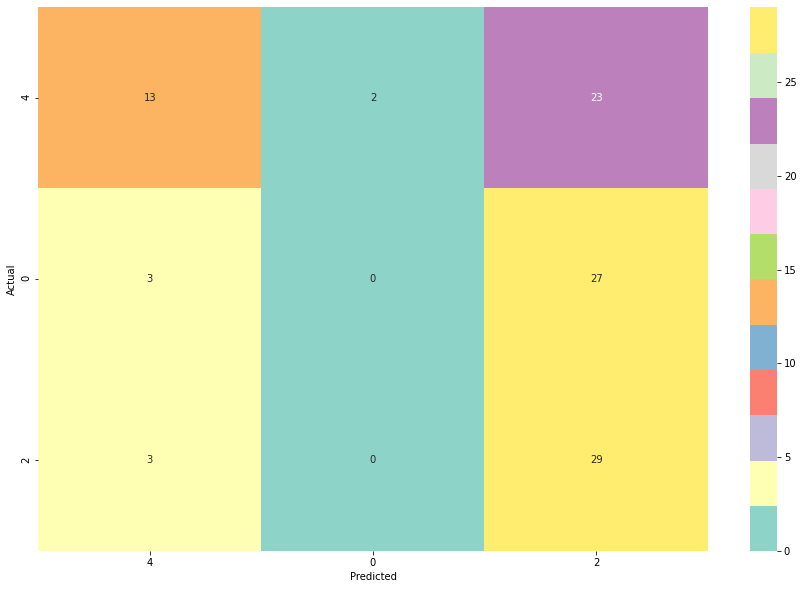

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

start = time.time()
clf = MultinomialNB()
#classifier = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),('classifier', LinearSVC(C=10))])
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, df['Category'], test_size=0.2, random_state=11)
clf.fit(X_train, y_train)
end = time.time()

print("Accuracy: " + str(clf.score(X_test, y_test)) + ", Time duration: " + str(end - start))

y_pred = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=df.Category.unique(), yticklabels=df.Category.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
